count    1000.000000
mean      806.772537
std       257.422153
min        32.809361
25%       633.031618
50%       791.431014
75%       960.319715
max      2096.446913
Name: CLV, dtype: float64


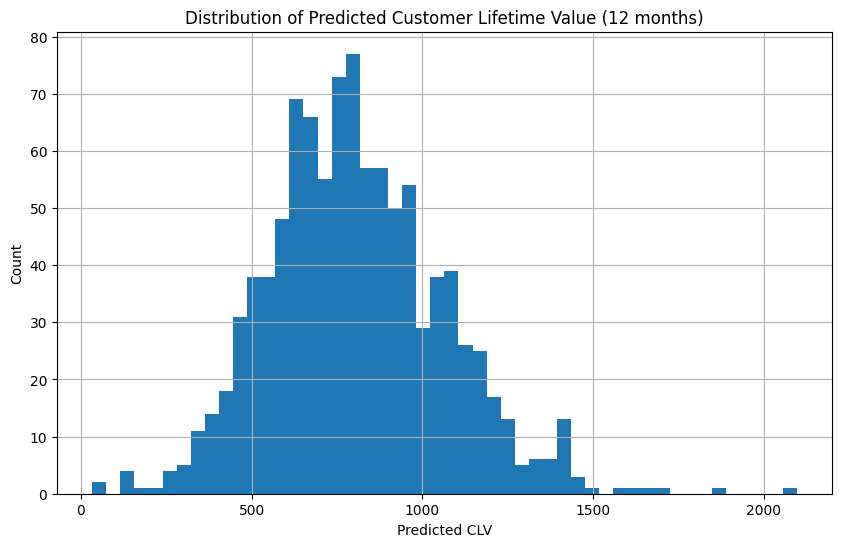


Top 10% of customers by predicted CLV:
             frequency  recency       T  monetary_value          CLV
customer_id                                                         
973               18.0    741.0   755.0      326.680727  2096.446913
16                19.0    894.0   983.0      335.253782  1876.458610
381               20.0   1030.0  1080.0      315.109145  1719.646215
209               18.0   1082.0  1086.0      331.214752  1648.876502
606               14.0    698.0   797.0      320.790326  1621.782249
...                ...      ...     ...             ...          ...
774               13.0    873.0  1010.0      283.301223  1146.414548
169               11.0   1063.0  1071.0      334.265298  1142.172069
444               13.0    849.0  1074.0      295.115172  1141.967634
218               12.0    901.0   915.0      279.207015  1140.181255
761               11.0    992.0  1031.0      324.402515  1139.709866

[100 rows x 5 columns]

Average predicted CLV by product categ

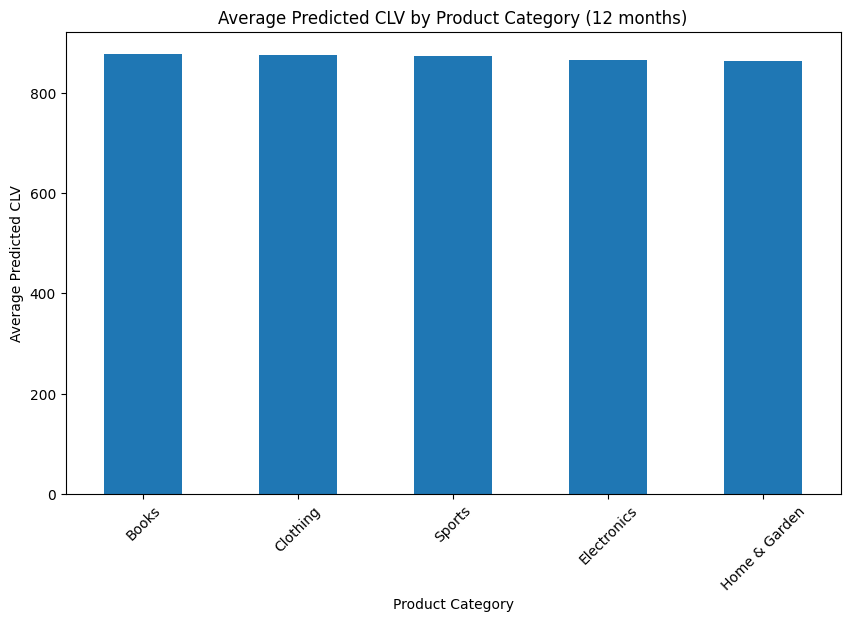


Predictive CLV results saved to 'predictive_clv_results.csv'


In [4]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('clv_sample_dataset.csv')
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

# Prepare the data
summary = summary_data_from_transaction_data(
    df,
    'customer_id',
    'purchase_date',
    'purchase_amount',
    observation_period_end=df['purchase_date'].max()
)

# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(summary['frequency'], summary['monetary_value'])

# Predict future transactions for the next 12 months
t = 12
summary['predicted_purchases'] = bgf.predict(t, summary['frequency'], summary['recency'], summary['T'])

# Calculate the expected average profit per transaction
summary['expected_average_profit'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

# Calculate CLV for the next 12 months
summary['CLV'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=t,
    discount_rate=0.01
)

# Display summary statistics of CLV
print(summary['CLV'].describe())

# Visualize CLV distribution
plt.figure(figsize=(10, 6))
summary['CLV'].hist(bins=50)
plt.title('Distribution of Predicted Customer Lifetime Value (12 months)')
plt.xlabel('Predicted CLV')
plt.ylabel('Count')
plt.show()

# Identify top 10% of customers by predicted CLV
top_customers = summary.nlargest(int(len(summary) * 0.1), 'CLV')
print("\nTop 10% of customers by predicted CLV:")
print(top_customers[['frequency', 'recency', 'T', 'monetary_value', 'CLV']])

# Analyze average CLV by product category
df_with_clv = df.merge(summary[['CLV']], left_on='customer_id', right_index=True)
category_clv = df_with_clv.groupby('product_category')['CLV'].mean().sort_values(ascending=False)
print("\nAverage predicted CLV by product category:")
print(category_clv)

# Visualize average CLV by product category
plt.figure(figsize=(10, 6))
category_clv.plot(kind='bar')
plt.title('Average Predicted CLV by Product Category (12 months)')
plt.xlabel('Product Category')
plt.ylabel('Average Predicted CLV')
plt.xticks(rotation=45)
plt.show()

# Save CLV results
summary.to_csv('predictive_clv_results.csv')
print("\nPredictive CLV results saved to 'predictive_clv_results.csv'")